In [35]:
%run functions.py

In [36]:
flow = pd.read_excel('Data\Dnister_flow.xlsx')
flow = flow.rename(columns={'Date': 'ds', 'Flow': 'y'})
flow = filter_29_february(flow)
flow_year_trend = define_trend(flow)
flow_m = remove_trend(flow, flow_year_trend)

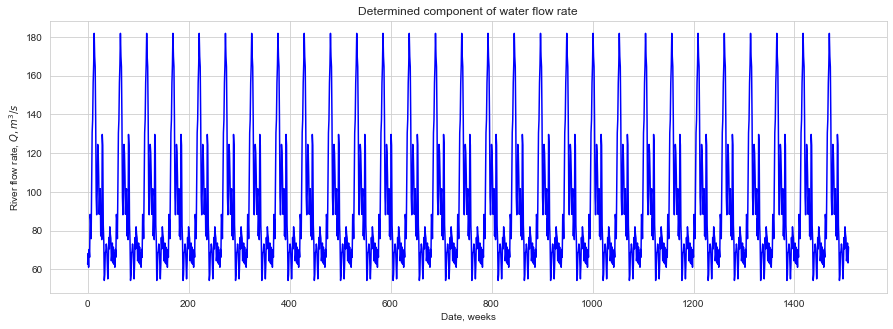

In [37]:
flow_full_trend = trend(flow, flow_year_trend)
flow_full_trend = convert_to_weekly(flow_full_trend)
water_flow_plot(flow_full_trend, title='Determined component of water flow rate')
plt.show()

<AxesSubplot:title={'center':'Dnister flow rate'}, xlabel='Date, weeks', ylabel='River flow rate, $Q$$, m^3/s$'>

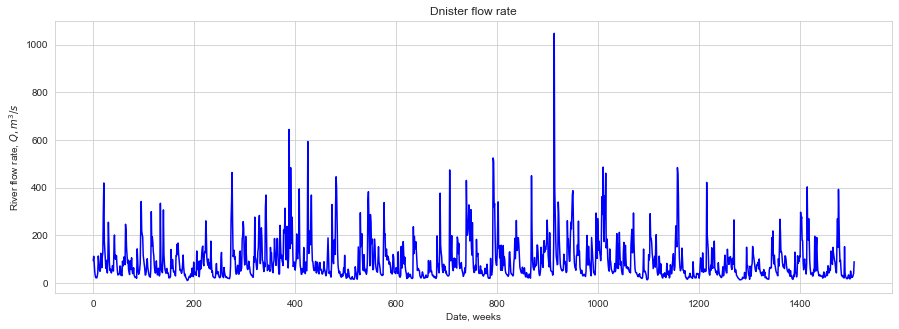

In [30]:
flow = convert_to_weekly(flow)
water_flow_plot(flow)

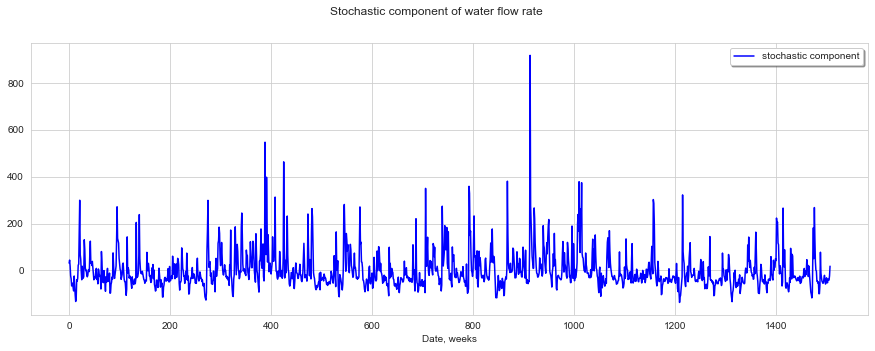

In [31]:
flow_m = convert_to_weekly(flow_m)
fig, axes = plt.subplots(figsize=(15, 5))
fig.suptitle('Stochastic component of water flow rate')
axes.plot(flow_m.y, label='stochastic component', color='blue')
axes.set_xlabel('Date, weeks')
axes.legend(shadow=True, fancybox=True)
plt.show()

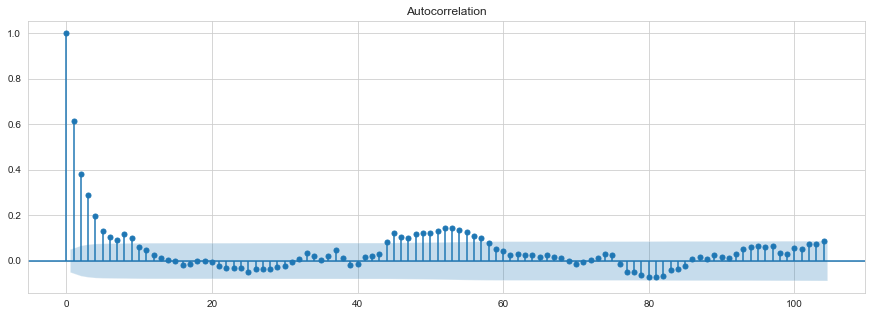

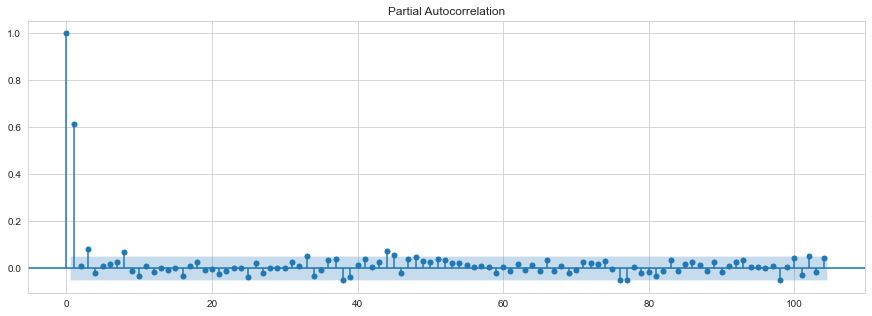

In [6]:
plt.rcParams.update({'figure.figsize': (15,5)})
plot_acf(flow.y, lags=104)
plot_pacf(flow.y, lags=104)
plt.show()

In [32]:
train = flow.loc[(flow.index >= 0) & (flow.index <= 1351)] # 26 years (1991-2016)
test = flow.loc[(flow.index >= 1352) & (flow.index <= 1507)] # 3 years (2017-2019)
trend_segment = flow_full_trend.loc[(flow_full_trend.index >= 1352) & (flow_full_trend.index <= 1507)]

<AxesSubplot:title={'center':'Dnister flow rate (2017-2019)'}, xlabel='Date, weeks', ylabel='River flow rate, $Q$$, m^3/s$'>

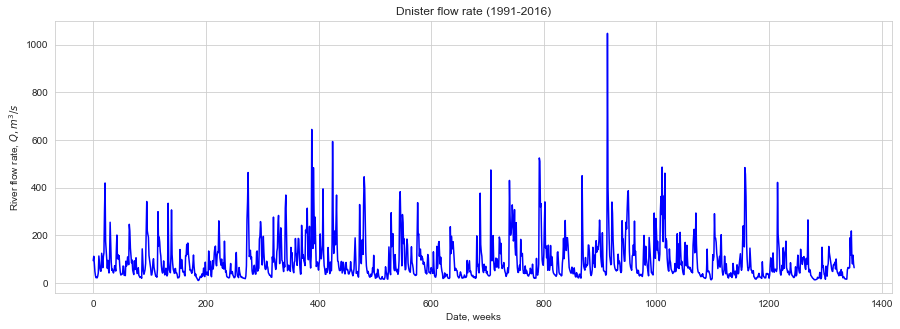

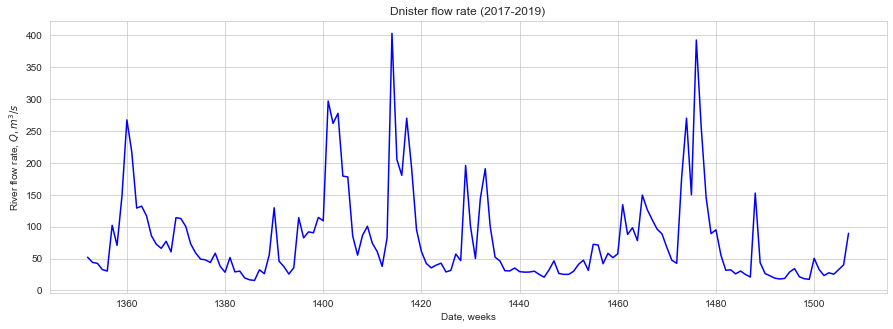

In [34]:
water_flow_plot(train, title='Dnister flow rate (1991-2016)')
water_flow_plot(test, title='Dnister flow rate (2017-2019)')

In [16]:
from time import time

In [18]:
model = sm.tsa.statespace.SARIMAX(train.y,
                                order=(3, 0, 9),
                                seasonal_order=(1, 2, 3, 52))

In [19]:
start = time()
model_fit = model.fit()
end = time()
print(f'Model fitting time: {end-start}')
print(model_fit.summary())

C:\Users\mixas\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:227: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\mixas\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:231: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index = pd.Int64Index(self._index.tolist() + [value])
C:\Users\mixas\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:227: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
C:\Users\mixas\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:231: FutureWarning: pandas.Int64Index is depreca

Model fitting time: 2689.9935162067413
                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                 1352
Model:             SARIMAX(3, 0, 9)x(1, 2, [1, 2, 3], 52)   Log Likelihood               -7307.129
Date:                                    Sun, 12 Jun 2022   AIC                          14648.258
Time:                                            17:10:31   BIC                          14735.456
Sample:                                                 0   HQIC                         14681.041
                                                   - 1352                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      

In [20]:
model_fit.aic

14648.258236325219

C:\Users\mixas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


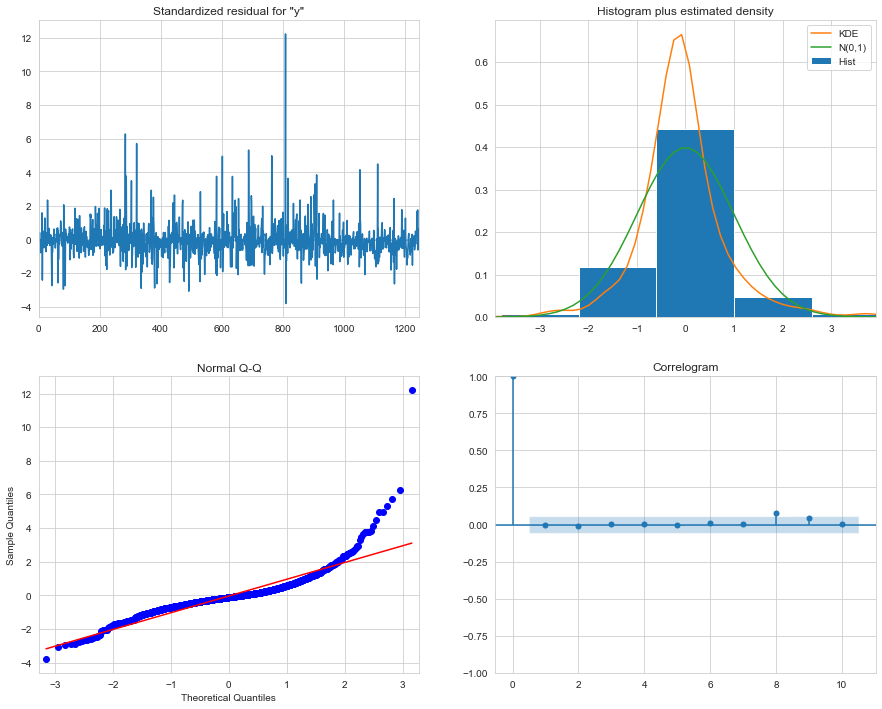

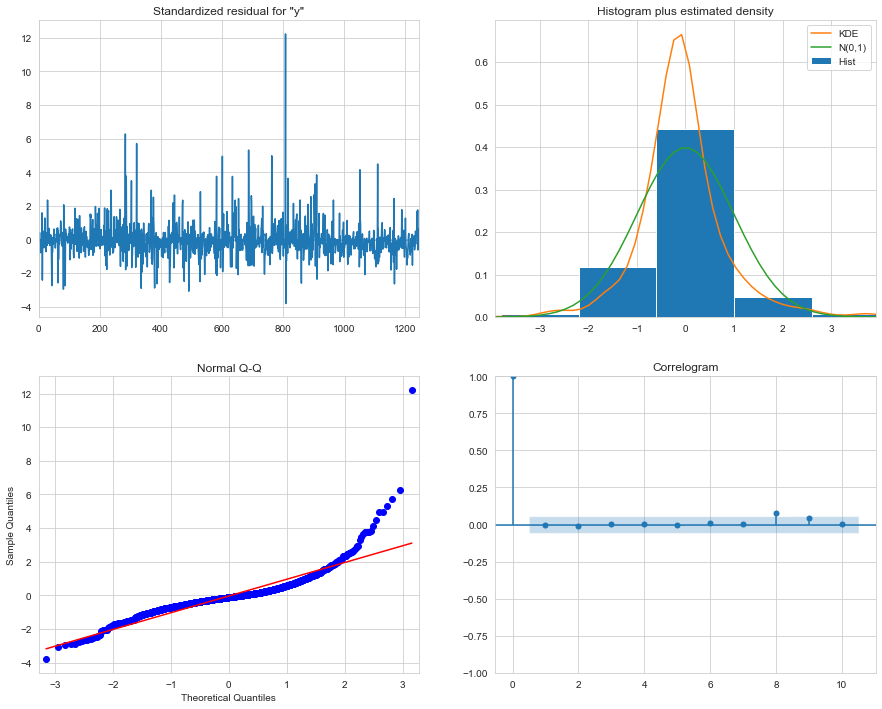

In [21]:
model_fit.plot_diagnostics(figsize=(15,12))

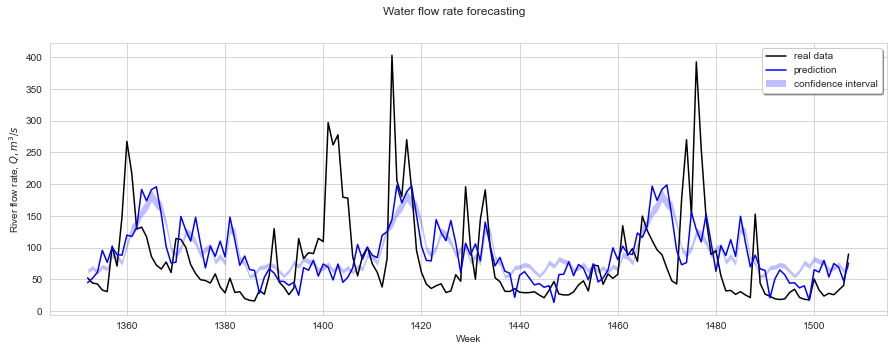

In [22]:
lower_series = trend_segment.copy()
upper_series = trend_segment.copy()
lower_series.y = lower_series.y*0.95
upper_series.y = upper_series.y*1.05

predictions = model_fit.forecast(156)
predictions = pd.DataFrame(predictions).rename(columns={'predicted_mean': 'y'})
fig, axes = plt.subplots(figsize=(15, 5))
fig.suptitle('Water flow rate forecasting')
axes.plot(test.y, label='real data', color='black')
axes.plot(predictions.y, label='prediction', color='blue')
axes.fill_between(lower_series.index, lower_series.y, upper_series.y, alpha=.25, linewidth=0, color='blue', label='confidence interval')
axes.set_xlabel('Week')
axes.set_ylabel('River flow rate, ' + r'$Q$' + r'$, m^3/s$')
axes.legend(shadow=True, fancybox=True)
plt.show()

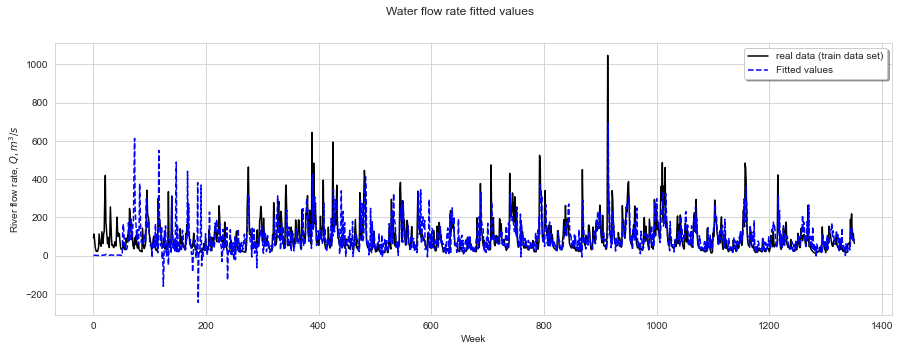

In [23]:
fig, axes = plt.subplots(figsize=(15, 5))
fig.suptitle('Water flow rate fitted values')
axes.plot(train[0:].y, label='real data (train data set)', color='black')
axes.plot(model_fit.fittedvalues[0:], label='Fitted values', color='blue', linestyle='--')
axes.set_xlabel('Week')
axes.set_ylabel('River flow rate, ' + r'$Q$' + r'$, m^3/s$')
axes.legend(shadow=True, fancybox=True)
plt.show()